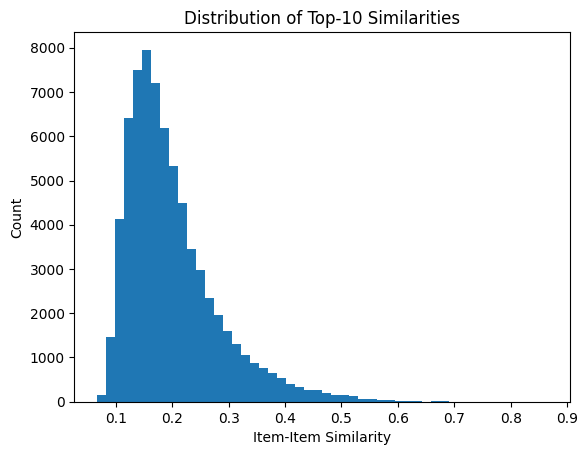

In [3]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, lil_matrix
from sklearn.metrics.pairwise import cosine_distances
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# 1) Load & index ratings
ratings = pd.read_csv("subset_ratings.csv", usecols=["userId","movieId","rating"])
uid2idx = {u:i for i,u in enumerate(ratings.userId.unique())}
mid2idx = {m:i for i,m in enumerate(ratings.movieId.unique())}
idx2mid = {i:m for m,i in mid2idx.items()}
ratings["u_idx"] = ratings.userId.map(uid2idx)
ratings["m_idx"] = ratings.movieId.map(mid2idx)
n_users, n_items = len(uid2idx), len(mid2idx)

# 2) Split per user
def split_per_user(df, frac=0.2, seed=42):
    train_list, test_list = [], []
    for _, g in df.groupby("userId"):
        if len(g)<2:
            train_list.append(g)
        else:
            tr, te = train_test_split(g, test_size=frac, random_state=seed)
            train_list.append(tr); test_list.append(te)
    return pd.concat(train_list), pd.concat(test_list)
train_df, _ = split_per_user(ratings)

# 3) Build item×user matrix & user-mean center for adjusted cosine
train_mat = csr_matrix((train_df.rating.values, (train_df.m_idx, train_df.u_idx)), shape=(n_items,n_users))
user_sum    = np.asarray(train_mat.sum(axis=1)).ravel()
user_counts = np.diff(train_mat.indptr)
item_means  = np.divide(user_sum, user_counts, out=np.zeros_like(user_sum), where=user_counts>0)
train_mc = train_mat.astype(np.float32)
for i in range(n_items):
    start, end = train_mc.indptr[i], train_mc.indptr[i+1]
    train_mc.data[start:end] -= item_means[i]

# 4) Compute full item-item cosine similarity
dist = cosine_distances(train_mc)
full_sim = 1.0 - dist
np.fill_diagonal(full_sim, 0.0)

# 5) Build a sparse top-K similarity matrix
K = 10
sim_mat = lil_matrix((n_items,n_items), dtype=np.float32)
for i in range(n_items):
    nbrs = np.argpartition(full_sim[i], -K)[-K:]
    nbrs = nbrs[np.argsort(full_sim[i][nbrs])[::-1]]
    vals = full_sim[i, nbrs]
    mask = vals > 0
    sim_mat.rows[i] = nbrs[mask].tolist()
    sim_mat.data[i] = vals[mask].tolist()
sim_mat = sim_mat.tocsr()

# 6a) Visualize similarity distribution
sim_values = sim_mat.data
plt.figure()
plt.hist(sim_values, bins=50)
plt.xlabel("Item-Item Similarity")
plt.ylabel("Count")
plt.title("Distribution of Top-10 Similarities")
plt.show()

# 6b) Display nearest neighbors for first 5 movies
neighbors = []
for i in range(5):
    start, end = sim_mat.indptr[i], sim_mat.indptr[i+1]
    for nbr, s in zip(sim_mat.indices[start:end], sim_mat.data[start:end]):
        neighbors.append({
            "movieId":   idx2mid[i],
            "neighbor":  idx2mid[nbr],
            "similarity": s
        })
df_neighbors = pd.DataFrame(neighbors)
